In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib inline

In [135]:
# Get in dataset
data_features_test = pd.read_csv("datasets/energy-informatics-2020/csvDataFeaturesTest.csv", sep=";")

# Take out only data corresponing to attacks and remove the column labelling it as an attack
data_features_attacks = data_features_test.to_numpy()[238279:, :21]
print(np.count_nonzero(np.isnan(data_features_attacks)))
# Set negative values to 0
data_features_attacks = np.where(data_features_attacks >= 0, data_features_attacks, 0)
data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')


0


In [136]:
BUFFER_SIZE = 10000
BATCH_SIZE = 50

In [137]:
# Batch and shuffle data

train_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[:9000]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[9000:]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

In [138]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            # input layer
            tf.keras.layers.InputLayer(input_shape=(21, 1)),
            # hidden layers
            tf.keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
            tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
            tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
            tf.keras.layers.Flatten(),
            # output layer
            tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        self.decoder = tf.keras.Sequential([
            # input layer
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            # hidden layers
            tf.keras.layers.Dense(units=21*100, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(21,100)),
            # transposed convolutional layers go in the opposite direction of a normal convolution
            # reshapes and upscales
            # accepts an input volume from a previous layer
            # produces an output that is larger than the input volume
            # maintains a connectivity pattern between the input and the output
            tf.keras.layers.Conv1DTranspose(filters=64, kernel_size=1, padding='same', activation='relu'),
            tf.keras.layers.Conv1DTranspose(filters=32, kernel_size=1, padding='same', activation='relu'),
            tf.keras.layers.Conv1DTranspose(filters=16, kernel_size=1, padding='same', activation='relu'),
            # output layer
            tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, data):
        mean, logvar = tf.split(self.encoder(data), num_or_size_splits=2, axis=1)
        return mean, logvar

    # sample from a unit Gaussian, and then shift the randomly sampled by the latent 
    # distribution's mean and scale it by the latent distribution's variance 
    # use log variance so the model doesn't learn negative values
    def reparameterise(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [139]:
# try removing weight from KL divergence
# might be KL divergence blowing up that's causing nans
# alos try wider prior
# sigmoid might be causing vanishing gradients but there doesn't seem to be a good alternative

In [140]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    s = -0.5 * ((sample-mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
    return tf.reduce_sum(s, axis=raxis)

def compute_loss(model, data):
    mean, logvar = model.encode(data)
    z = model.reparameterise(mean, logvar)
    data_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=data_logit, labels=data)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [141]:
# `tf.function` causes the function to be compiled
@tf.function
def train_step(model, data, optimizer):
    # GradientTape will automatically watch any trainable variables that are accessed inside 
    with tf.GradientTape() as tape:
        loss = compute_loss(model, data)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [142]:
def predict(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterise(mean, logvar)
    predictions = model.sample(z)
    return predictions

In [143]:

latent_dim = 1200
num_examples_to_generate = 200
epochs = 20

for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :]
    print(test_sample.shape)

# random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

(50, 21, 1)


In [144]:
predictions = np.array([])
for epoch in range(epochs):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()

    predictions = np.append(predictions, predict(model, epoch, test_sample))

In [145]:
np.count_nonzero(np.isnan(predictions)), predictions.size

(0, 21000)

In [146]:
size = int(predictions.shape[0]/21)
predictions = predictions.reshape(size, 21)

In [147]:
data_labels = [name for name in data_features_test.columns]

frame_len_actual = data_features_test["frameLen"]
frame_len_generated = predictions[:,0]

/tmp/ipykernel_371828/3958339257.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


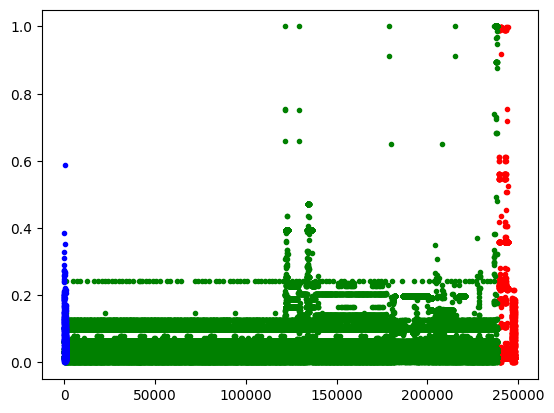

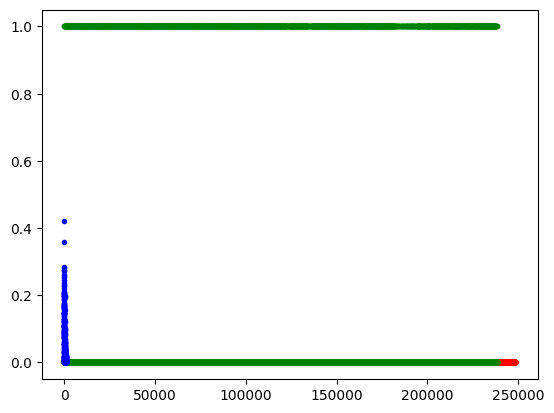

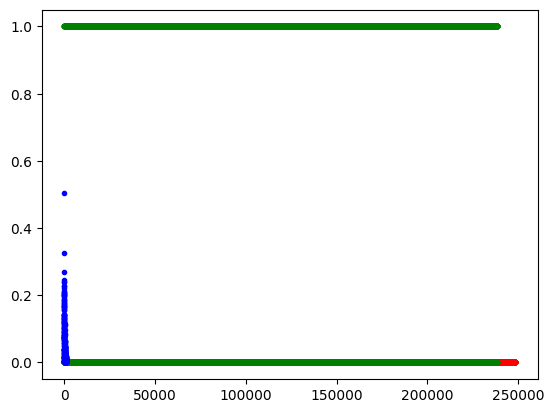

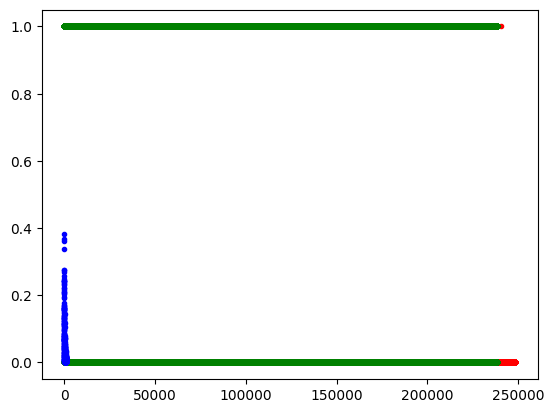

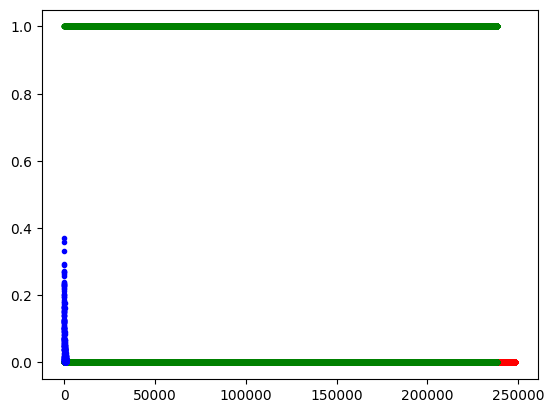

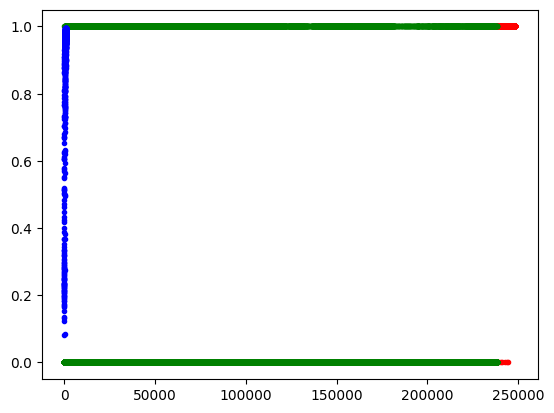

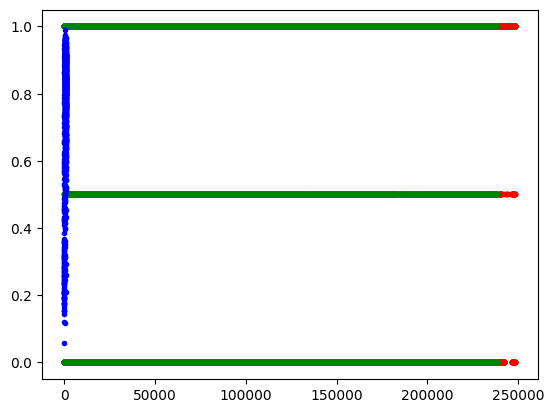

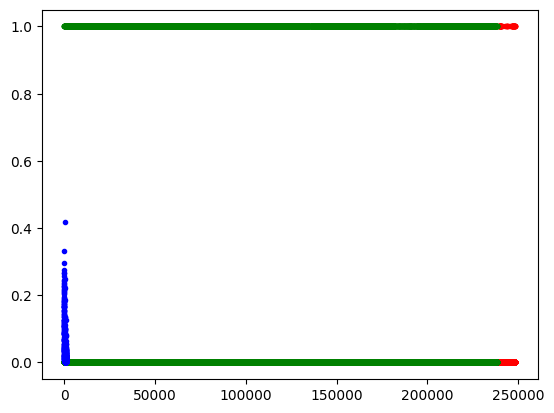

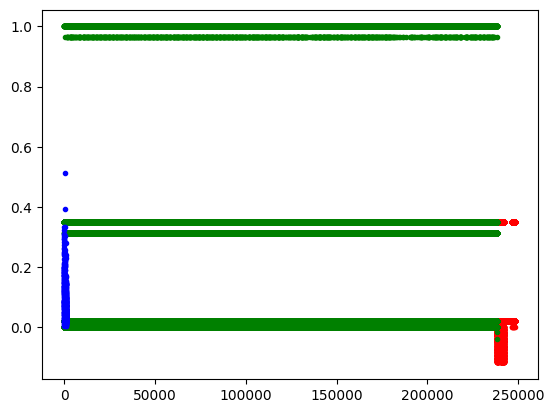

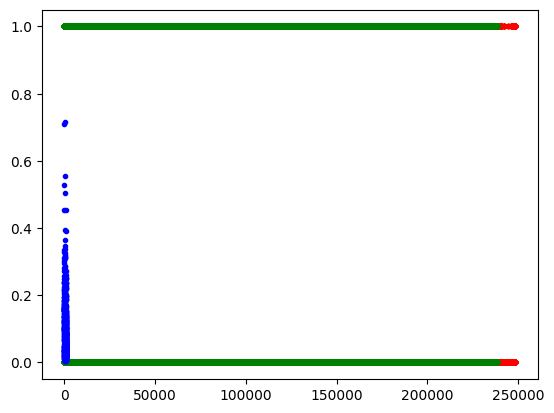

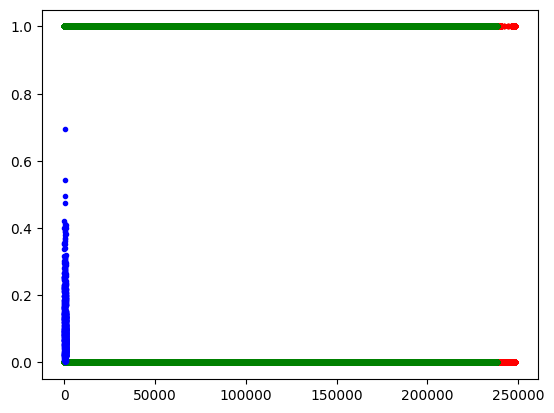

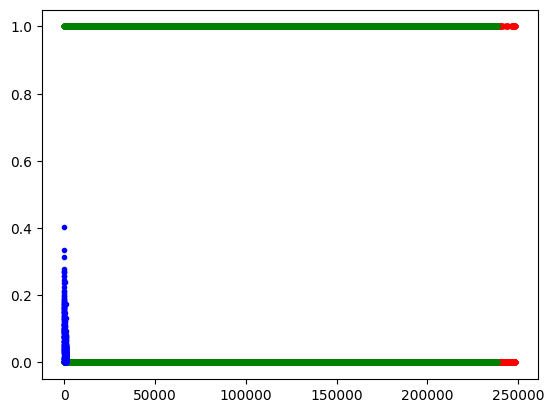

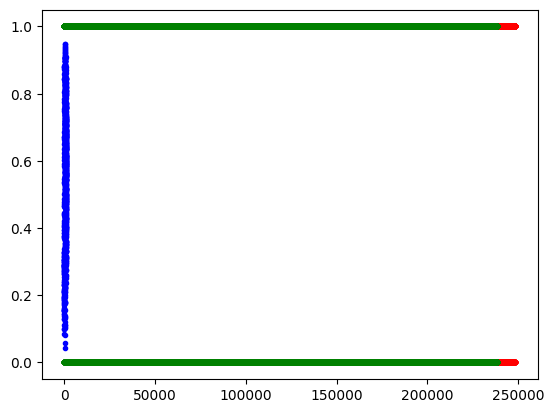

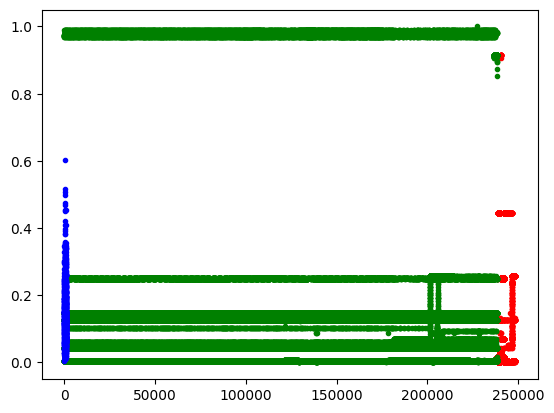

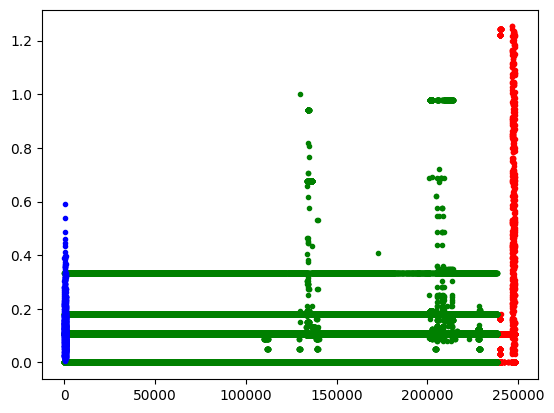

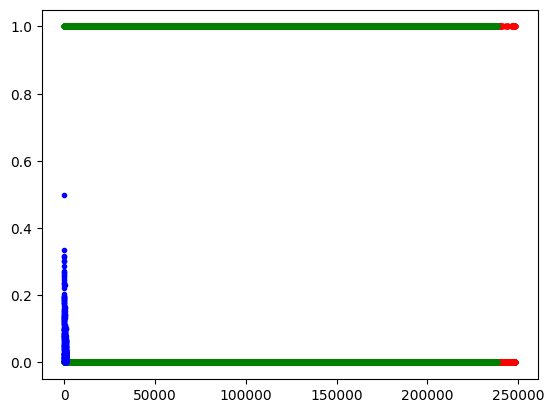

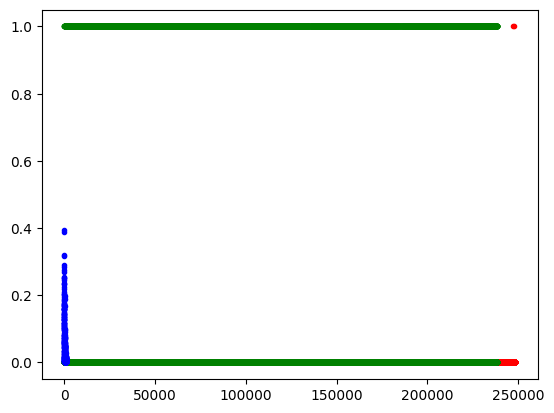

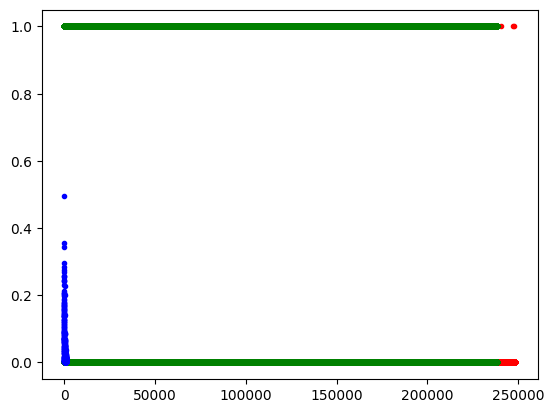

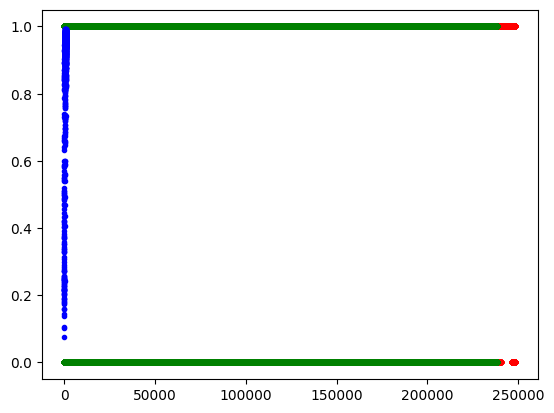

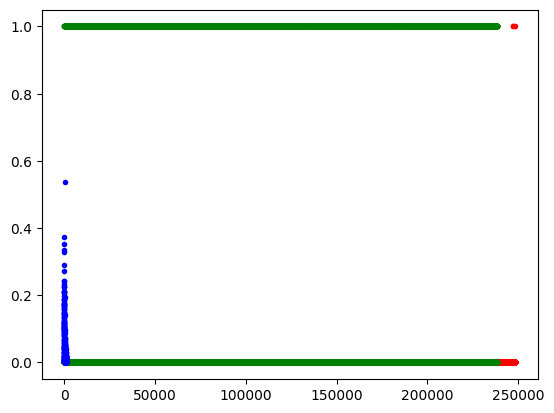

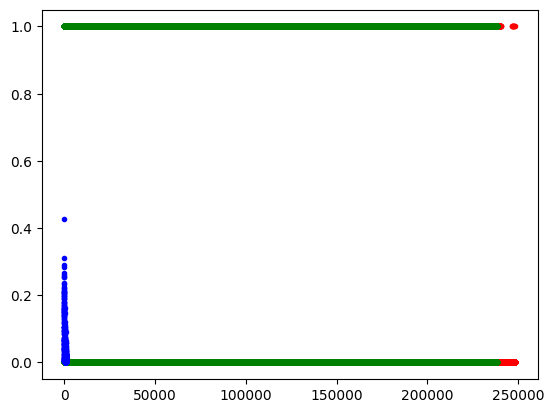

In [148]:
for i in range(21):
    feature = data_labels[i]
    plt.figure(i)
    plt.plot(np.arange(238279, 238279+9999), data_features_test[feature][238279:], '.r') #attacks
    plt.plot(np.arange(238279), data_features_test[feature][:238279], '.g') # not attacks
    plt.plot(predictions[:,i], '.b')